In [1]:
import numpy as np
from Py6S import *
import time as T
from joblib import Parallel, delayed
from scipy.interpolate import griddata,interpn,RegularGridInterpolator
import math
import os
import datetime
import cv2
from ftplib import FTP
import rioxarray
import xarray as xr
import multiprocessing
import paramiko
from scp import SCPClient
import subprocess

/data01/people/liwei/anaconda3/envs/python36/lib/python3.6/site-packages/paramiko/transport.py:33: CryptographyDeprecationWarning: Python 3.6 is no longer supported by the Python core team. Therefore, support for it is deprecated in cryptography and will be removed in a future release.
  from cryptography.hazmat.backends import default_backend


In [144]:
sza = np.linspace(0,80,81)
vza = np.linspace(0,80,81)
water = np.linspace(0,7,71)
ozone = np.linspace(0.2,0.4,41)
AOT = np.linspace(0,2,21)
raa = np.linspace(0,180,181)
al = np.linspace(0,8,81)
AERO_TYPE = np.array([0,1])

LUT_PATH = '/data01/GEO/INPUT/LUT/'

In [108]:
def water_6s(i,w):
    s = SixS()
    s.atmos_profile = AtmosProfile.UserWaterAndOzone(water[w],0.2)
    s.aero_profile = AeroProfile.PredefinedType(i+1)
    s.aot550 = 0.2
    s.wavelength = Wavelength(band[0,0],band[band.shape[0]-1,0],band[:,1])
    s.altitudes.set_sensor_satellite_level()
    s.altitudes.set_target_custom_altitude(0)
    s.geometry = Geometry.User()
    s.geometry.solar_z = 30
    s.geometry.solar_a = 50
    s.geometry.view_z = 30
    s.geometry.view_a = 0
    
    s.atmos_corr = AtmosCorr.AtmosCorrLambertianFromReflectance(0.2)
    s.run()
    
    
    f1 = 1/(s.outputs.transmittance_total_scattering.total*s.outputs.transmittance_global_gas.total)
    return(f1, s.outputs.coef_xb, s.outputs.coef_xc)

In [110]:
def ozone_6s(i,o):
    AERO = AERO_TYPE + 1
    s = SixS()
    s.atmos_profile = AtmosProfile.UserWaterAndOzone(2,ozone[o])
    s.aero_profile = AeroProfile.PredefinedType(i+1)
    s.aot550 = 0.2
    s.wavelength = Wavelength(band[0,0],band[band.shape[0]-1,0],band[:,1])
    s.altitudes.set_sensor_satellite_level()
    s.altitudes.set_target_custom_altitude(0)
    s.geometry = Geometry.User()
    s.geometry.solar_z = 30
    s.geometry.solar_a = 50
    s.geometry.view_z = 30
    s.geometry.view_a = 0
    
    s.atmos_corr = AtmosCorr.AtmosCorrLambertianFromReflectance(0.2)
    s.run()
    
    
    f1 = 1/(s.outputs.transmittance_total_scattering.total*s.outputs.transmittance_global_gas.total)
    return(f1, s.outputs.coef_xb, s.outputs.coef_xc)

In [111]:
def aot_6s(i,aot):
    s = SixS()
    s.atmos_profile = AtmosProfile.UserWaterAndOzone(2,0.2)
    s.aero_profile = AeroProfile.PredefinedType(i+1)
    s.aot550 = AOT[aot]
    s.wavelength = Wavelength(band[0,0],band[band.shape[0]-1,0],band[:,1])
    s.altitudes.set_sensor_satellite_level()
    s.altitudes.set_target_custom_altitude(0)
    s.geometry = Geometry.User()
    s.geometry.solar_z = 30
    s.geometry.solar_a = 50
    s.geometry.view_z = 30
    s.geometry.view_a = 0
    
    s.atmos_corr = AtmosCorr.AtmosCorrLambertianFromReflectance(0.2)
    s.run()
    
    
    f1 = 1/(s.outputs.transmittance_total_scattering.total*s.outputs.transmittance_global_gas.total)
    return(f1, s.outputs.coef_xb, s.outputs.coef_xc)

In [113]:
def al_6s(i,a):
    s = SixS()
    s.atmos_profile = AtmosProfile.UserWaterAndOzone(2,0.2)
    s.aero_profile = AeroProfile.PredefinedType(i+1)
    s.aot550 = 0.2
    s.wavelength = Wavelength(band[0,0],band[band.shape[0]-1,0],band[:,1])
    s.altitudes.set_sensor_satellite_level()
    s.altitudes.set_target_custom_altitude(al[a])
    s.geometry = Geometry.User()
    s.geometry.solar_z = 30
    s.geometry.solar_a = 50
    s.geometry.view_z = 30
    s.geometry.view_a = 0
    
    s.atmos_corr = AtmosCorr.AtmosCorrLambertianFromReflectance(0.2)
    s.run()
    
    
    f1 = 1/(s.outputs.transmittance_total_scattering.total*s.outputs.transmittance_global_gas.total)
    return(f1, s.outputs.coef_xb, s.outputs.coef_xc)

In [145]:
def sza_6s(i,S):
    s = SixS()
    s.atmos_profile = AtmosProfile.UserWaterAndOzone(2,0.2)
    s.aero_profile = AeroProfile.PredefinedType(i+1)
    s.aot550 = 0.2
    s.wavelength = Wavelength(band[0,0],band[band.shape[0]-1,0],band[:,1])
    s.altitudes.set_sensor_satellite_level()
    s.altitudes.set_target_custom_altitude(0)
    s.geometry = Geometry.User()
    s.geometry.solar_z = sza[S]
    s.geometry.solar_a = 50
    s.geometry.view_z = 30
    s.geometry.view_a = 0
    
    s.atmos_corr = AtmosCorr.AtmosCorrLambertianFromReflectance(0.2)
    s.run()
    
    
    f1 = 1/(s.outputs.transmittance_total_scattering.total*s.outputs.transmittance_global_gas.total)
    return(f1, s.outputs.coef_xb, s.outputs.coef_xc)

In [114]:
def vza_6s(i,v):
    s = SixS()
    s.atmos_profile = AtmosProfile.UserWaterAndOzone(2,0.2)
    s.aero_profile = AeroProfile.PredefinedType(i+1)
    s.aot550 = 0.2
    s.wavelength = Wavelength(band[0,0],band[band.shape[0]-1,0],band[:,1])
    s.altitudes.set_sensor_satellite_level()
    s.altitudes.set_target_custom_altitude(0)
    s.geometry = Geometry.User()
    s.geometry.solar_z = 30
    s.geometry.solar_a = 50
    s.geometry.view_z = vza[v]
    s.geometry.view_a = 0
    
    s.atmos_corr = AtmosCorr.AtmosCorrLambertianFromReflectance(0.2)
    s.run()
    
    
    f1 = 1/(s.outputs.transmittance_total_scattering.total*s.outputs.transmittance_global_gas.total)
    return(f1, s.outputs.coef_xb, s.outputs.coef_xc)

In [115]:
def raa_6s(i,r):
    s = SixS()
    s.atmos_profile = AtmosProfile.UserWaterAndOzone(2,0.2)
    s.aero_profile = AeroProfile.PredefinedType(i+1)
    s.aot550 = 0.2
    s.wavelength = Wavelength(band[0,0],band[band.shape[0]-1,0],band[:,1])
    s.altitudes.set_sensor_satellite_level()
    s.altitudes.set_target_custom_altitude(0)
    s.geometry = Geometry.User()
    s.geometry.solar_z = 30
    s.geometry.solar_a = raa[r]
    s.geometry.view_z = 30
    s.geometry.view_a = 0
    
    s.atmos_corr = AtmosCorr.AtmosCorrLambertianFromReflectance(0.2)
    s.run()
    
    
    f1 = 1/(s.outputs.transmittance_total_scattering.total*s.outputs.transmittance_global_gas.total)
    return(f1, s.outputs.coef_xb, s.outputs.coef_xc)

In [147]:
import matplotlib.pyplot as plt

def make_fig(i,x,y,Parameter,factor):
    
    ax1 = axes[i]

    ax1.tick_params(axis="y",which='major',length=5,direction='in',labelsize=8)
    ax1.tick_params(axis="x",which='major',length=5,direction='in',labelsize=8)


    ax1.spines['right'].set_color('none')
    ax1.spines['top'].set_color('none')



    # ax1.set_xticks(np.linspace(axis_min,axis_max,5))
    # ax1.set_yticks(np.linspace(axis_min,axis_max,5))
    
    # ax1.set_xlabel("{}".format(Parameter),fontsize=10)
    ax1.set_ylabel("X{}".format(factor),fontsize=10)

    ax1.plot(x,y[0:int(len(y)/2)],color='b',linewidth=2,linestyle='-',zorder=2,label='Maritime')
    ax1.plot(x,y[int(len(y)/2):],color='y',linewidth=2,linestyle='-',zorder=2,label='Continental')


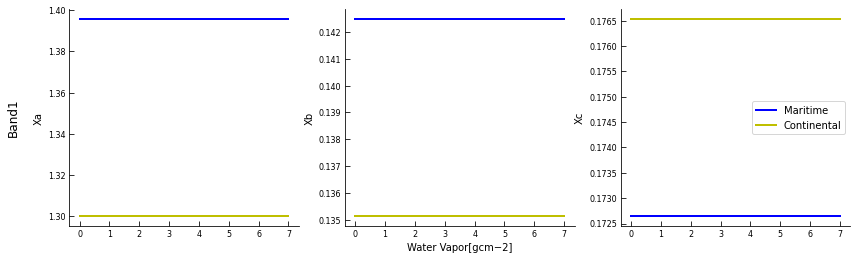

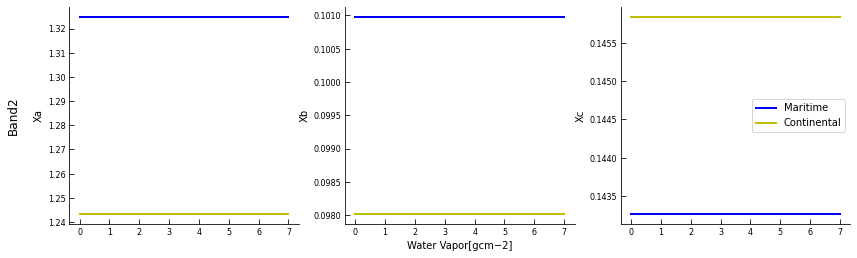

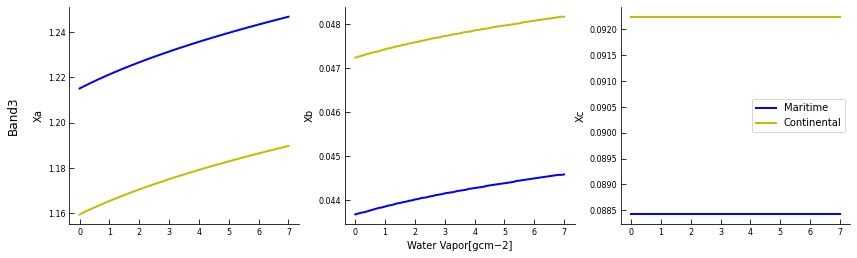

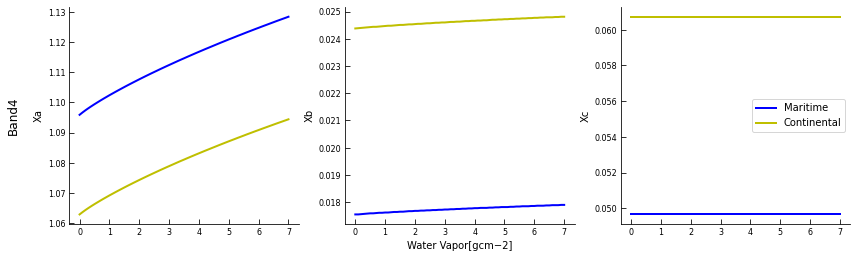

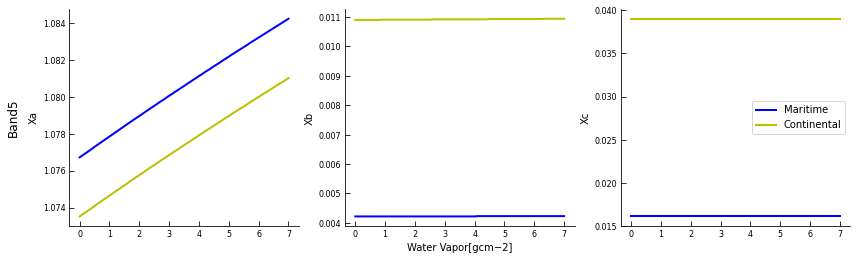

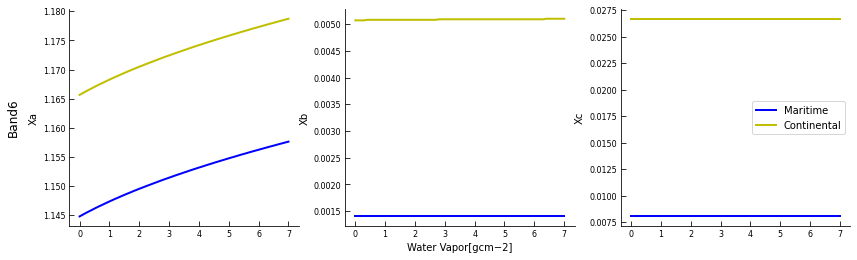

In [155]:
_input = water
_para = 'Water Vapor[gcm−2]'
for b in range(1,7):

    wl_band = "/data01/people/liwei/AHI_AC/AHI_SRF/sixs_band{}.csv".format(b)

    band = np.loadtxt(wl_band,delimiter=",")

    X = Parallel(n_jobs=20)(delayed(water_6s)(i,w) \
                                          for i in range (2)\
                                          for w in range (len(_input)))
    X = np.array(X)
    X1 = X[:,0]
    X2 = X[:,1]
    X3 = X[:,2]
    fig ,axes = plt.subplots(1,3, figsize=(14, 4))

    make_fig(0,_input,X1,_para,'a')
    make_fig(1,_input,X2,_para,'b')

    make_fig(2,_input,X3,_para,'c')
    plt.xlabel("{}".format(_para),fontsize=10,x=-0.7)
    plt.suptitle('Band{}'.format(b),fontsize=12,y=0.57,x=0.07,rotation=90)

    plt.legend(loc=0)
    fig.savefig('{}_Water.jpg'.format(b),dpi = 1000,bbox_inches = 'tight')
    plt.show()

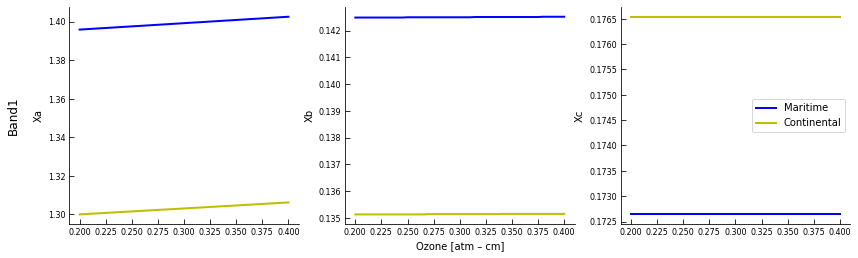

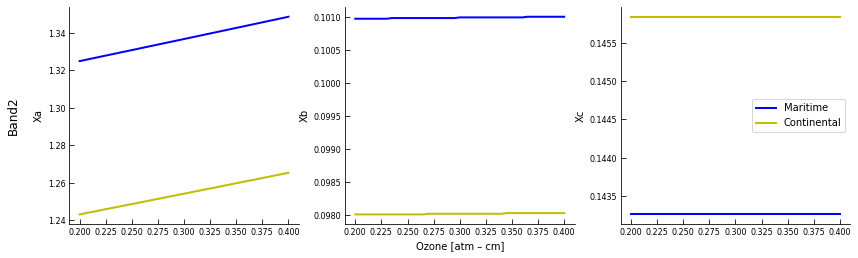

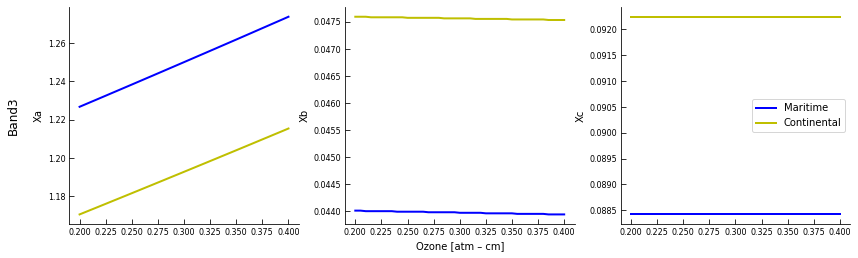

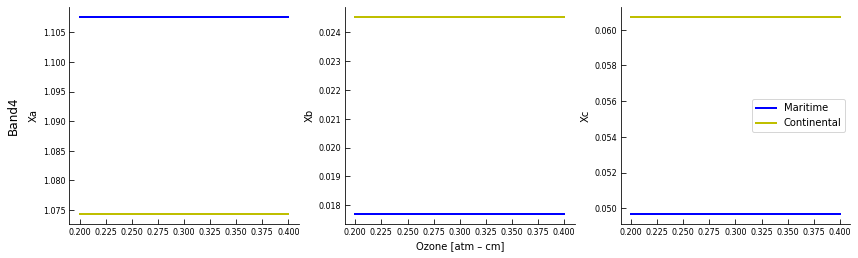

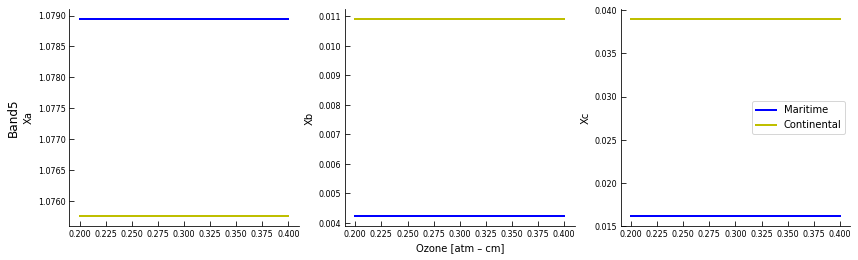

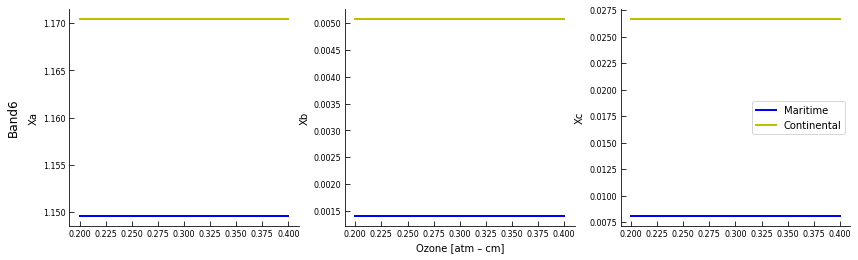

In [162]:
_input = ozone
_para = 'Ozone [atm – cm]'
for b in range(1,7):

    wl_band = "/data01/people/liwei/AHI_AC/AHI_SRF/sixs_band{}.csv".format(b)

    band = np.loadtxt(wl_band,delimiter=",")

    X = Parallel(n_jobs=20)(delayed(ozone_6s)(i,w) \
                                          for i in range (2)\
                                          for w in range (len(_input)))
    X = np.array(X)
    X1 = X[:,0]
    X2 = X[:,1]
    X3 = X[:,2]
    fig ,axes = plt.subplots(1,3, figsize=(14, 4))

    make_fig(0,_input,X1,_para,'a')
    make_fig(1,_input,X2,_para,'b')
    make_fig(2,_input,X3,_para,'c')
    plt.suptitle('Band{}'.format(b),fontsize=12,y=0.57,x=0.07,rotation=90)
    plt.xlabel("{}".format(_para),fontsize=10,x=-0.7)    
    plt.legend(loc=0)
    fig.savefig('{}_Ozone.jpg'.format(b),dpi = 1000,bbox_inches = 'tight')
    plt.show()

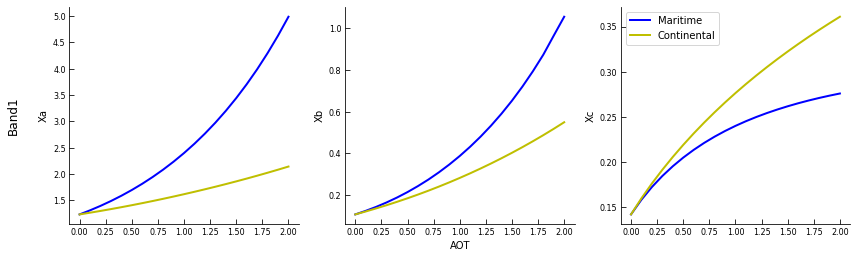

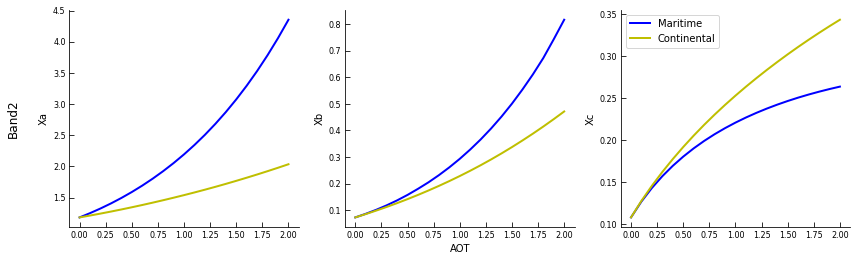

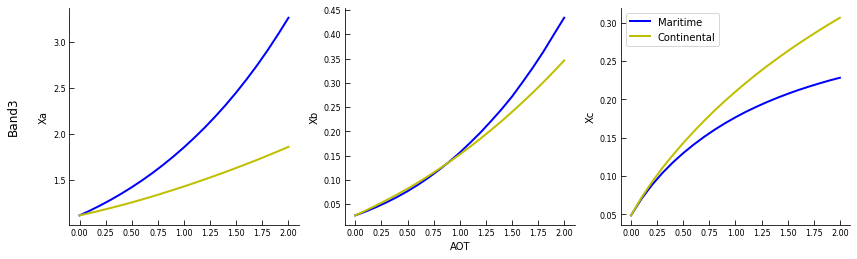

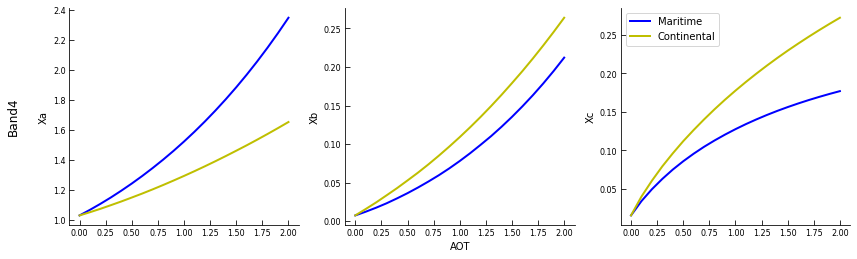

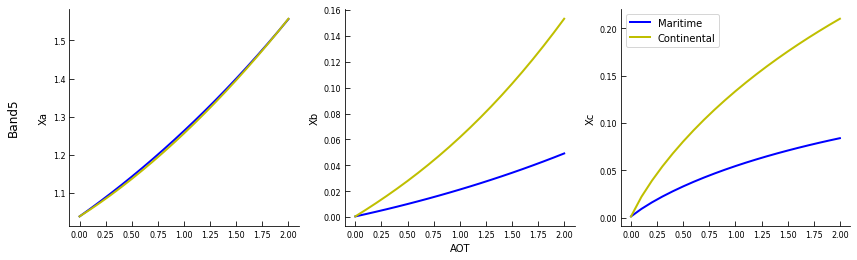

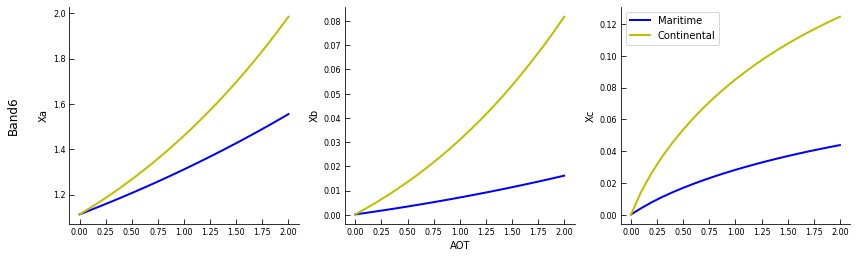

In [157]:
_input = AOT
_para = 'AOT'
for b in range(1,7):

    wl_band = "/data01/people/liwei/AHI_AC/AHI_SRF/sixs_band{}.csv".format(b)

    band = np.loadtxt(wl_band,delimiter=",")

    X = Parallel(n_jobs=20)(delayed(aot_6s)(i,aot) \
                                          for i in range (2)\
                                          for aot in range (len(_input)))
    X = np.array(X)
    X1 = X[:,0]
    X2 = X[:,1]
    X3 = X[:,2]
    fig ,axes = plt.subplots(1,3, figsize=(14, 4))

    make_fig(0,_input,X1,_para,'a')
    make_fig(1,_input,X2,_para,'b')
    make_fig(2,_input,X3,_para,'c')
    plt.suptitle('Band{}'.format(b),fontsize=12,y=0.57,x=0.07,rotation=90)
    plt.xlabel("{}".format(_para),fontsize=10,x=-0.7)

    plt.legend(loc=0)
    fig.savefig('{}_AOT.jpg'.format(b),dpi = 1000,bbox_inches = 'tight')
    plt.show()

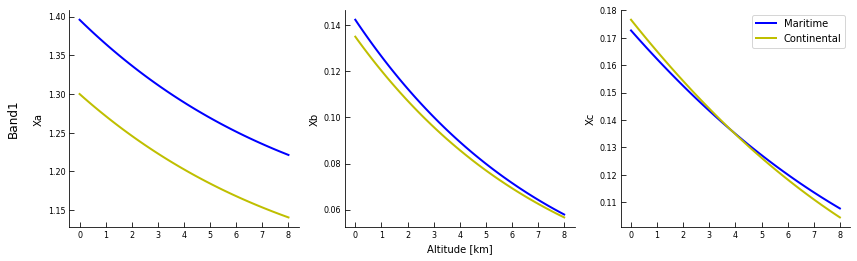

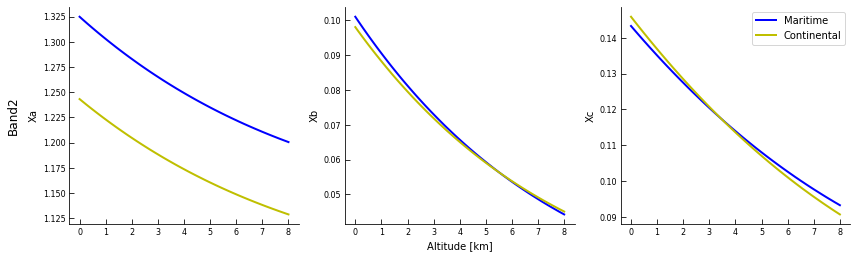

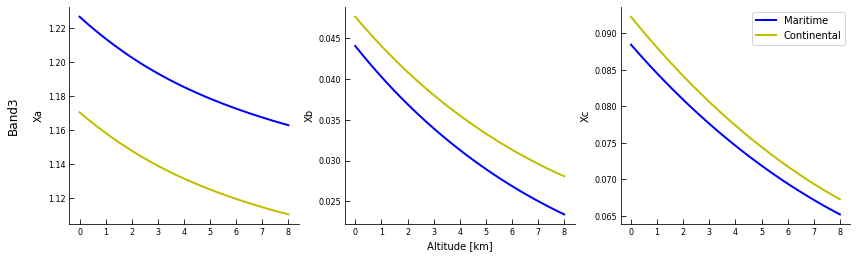

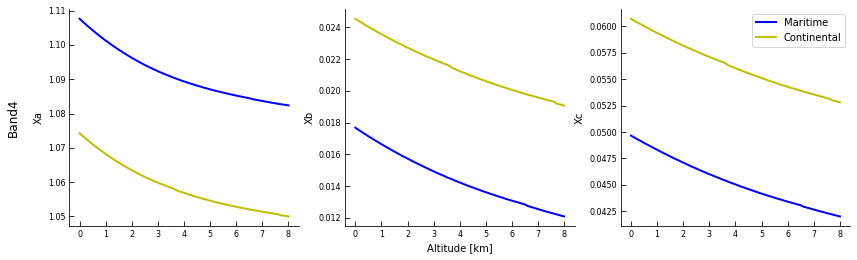

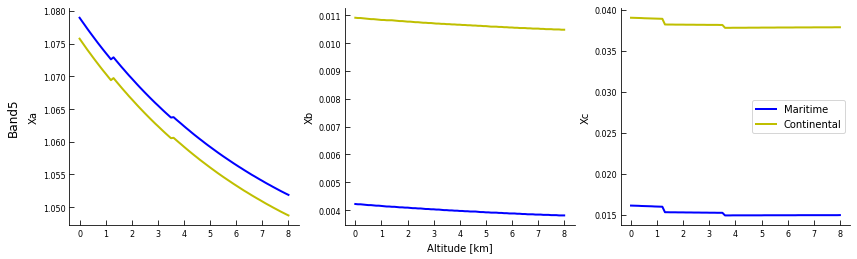

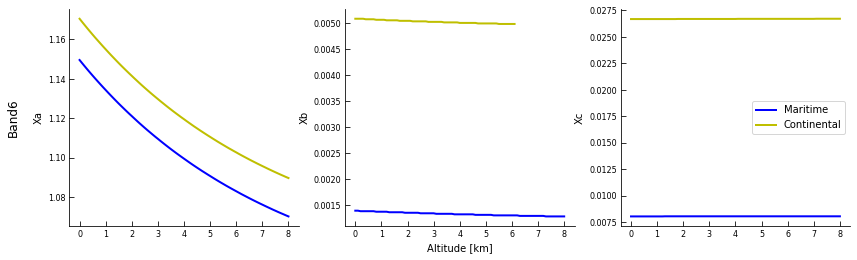

In [158]:
_input = al
_para = 'Altitude [km]'
for b in range(1,7):

    wl_band = "/data01/people/liwei/AHI_AC/AHI_SRF/sixs_band{}.csv".format(b)

    band = np.loadtxt(wl_band,delimiter=",")

    X = Parallel(n_jobs=20)(delayed(al_6s)(i,al) \
                                          for i in range (2)\
                                          for al in range (len(_input)))
    X = np.array(X)
    X1 = X[:,0]
    X2 = X[:,1]
    X3 = X[:,2]
    fig ,axes = plt.subplots(1,3, figsize=(14, 4))

    make_fig(0,_input,X1,_para,'a')
    make_fig(1,_input,X2,_para,'b')
    make_fig(2,_input,X3,_para,'c')
    plt.suptitle('Band{}'.format(b),fontsize=12,y=0.57,x=0.07,rotation=90)
    plt.xlabel("{}".format(_para),fontsize=10,x=-0.7)

    plt.legend(loc=0)
    fig.savefig('{}_AL.jpg'.format(b),dpi = 1000,bbox_inches = 'tight')
    plt.show()

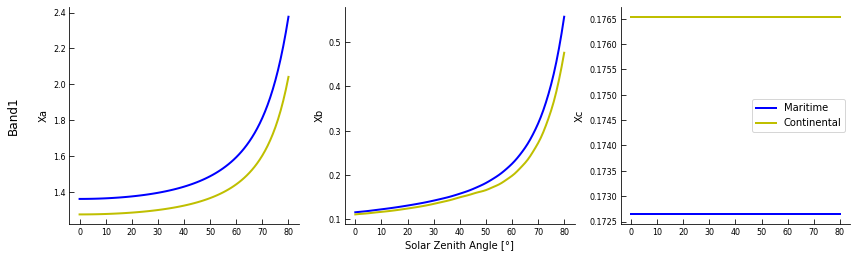

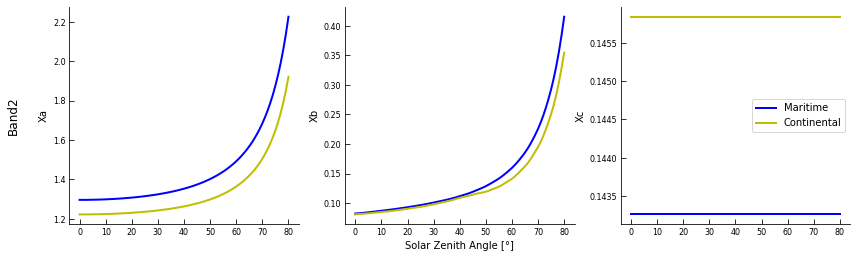

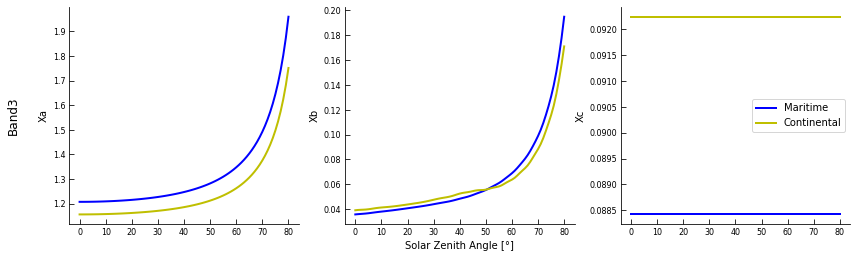

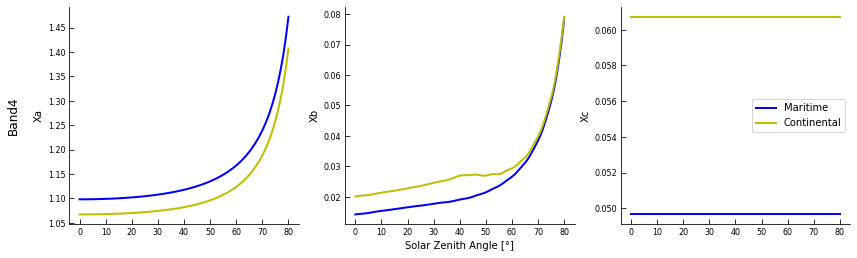

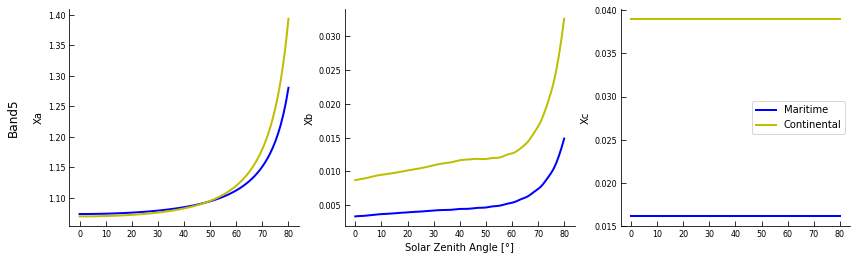

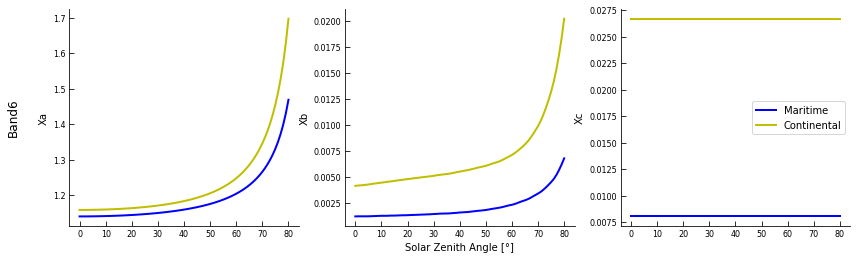

In [159]:
_input = sza
_para = 'Solar Zenith Angle [°]'
for b in range(1,7):

    wl_band = "/data01/people/liwei/AHI_AC/AHI_SRF/sixs_band{}.csv".format(b)

    band = np.loadtxt(wl_band,delimiter=",")

    X = Parallel(n_jobs=20)(delayed(sza_6s)(i,s) \
                                          for i in range (2)\
                                          for s in range (len(_input)))
    X = np.array(X)
    X1 = X[:,0]
    X2 = X[:,1]
    X3 = X[:,2]
    fig ,axes = plt.subplots(1,3, figsize=(14, 4))

    make_fig(0,_input,X1,_para,'a')
    make_fig(1,_input,X2,_para,'b')
    make_fig(2,_input,X3,_para,'c')
    plt.suptitle('Band{}'.format(b),fontsize=12,y=0.57,x=0.07,rotation=90)
    plt.xlabel("{}".format(_para),fontsize=10,x=-0.7)

    plt.legend(loc=0)
    fig.savefig('{}_SZA.jpg'.format(b),dpi = 1000,bbox_inches = 'tight')
    plt.show()

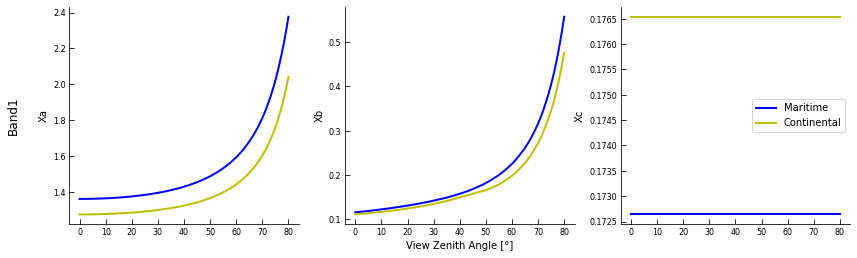

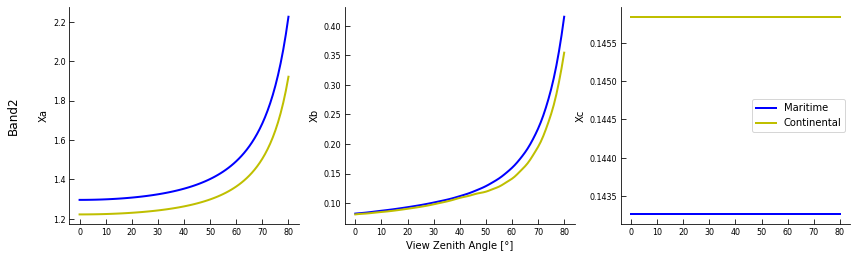

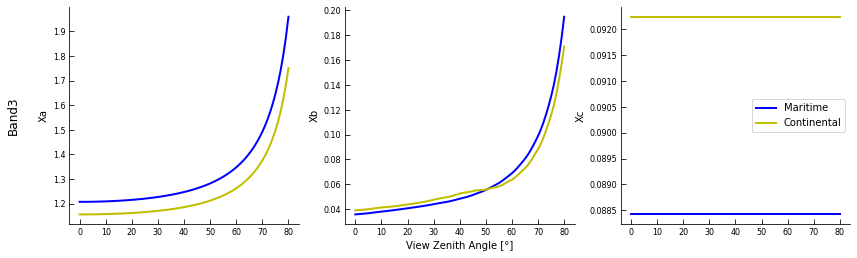

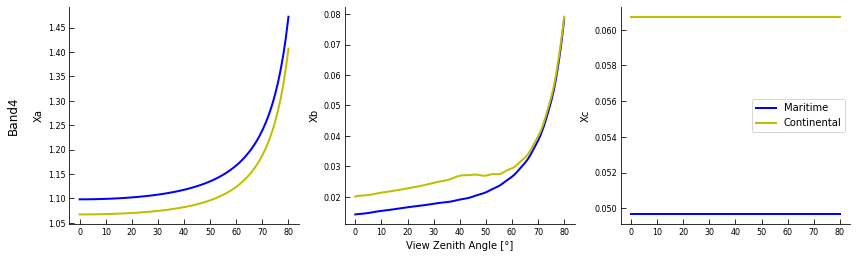

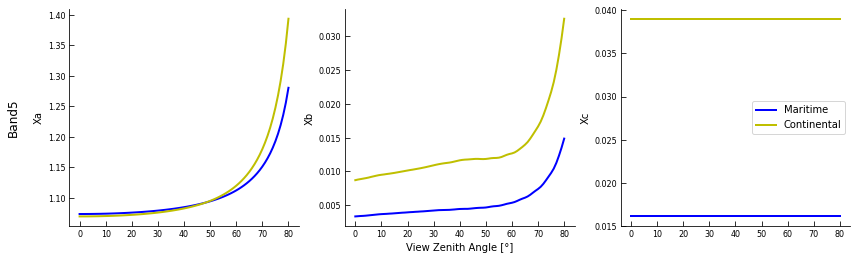

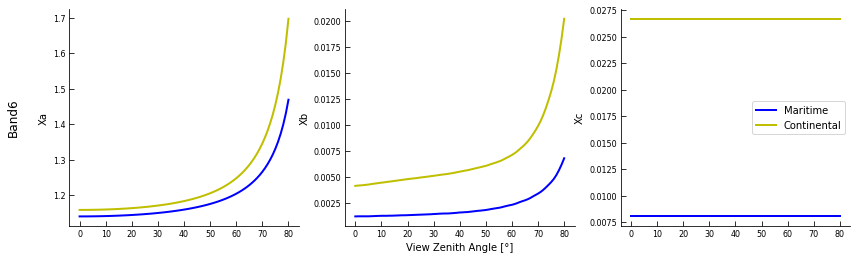

In [160]:
_input = vza
_para = 'View Zenith Angle [°]'
for b in range(1,7):

    wl_band = "/data01/people/liwei/AHI_AC/AHI_SRF/sixs_band{}.csv".format(b)

    band = np.loadtxt(wl_band,delimiter=",")

    X = Parallel(n_jobs=20)(delayed(vza_6s)(i,v) \
                                          for i in range (2)\
                                          for v in range (len(_input)))
    X = np.array(X)
    X1 = X[:,0]
    X2 = X[:,1]
    X3 = X[:,2]
    fig ,axes = plt.subplots(1,3, figsize=(14, 4))

    make_fig(0,_input,X1,_para,'a')
    make_fig(1,_input,X2,_para,'b')
    make_fig(2,_input,X3,_para,'c')
    plt.suptitle('Band{}'.format(b),fontsize=12,y=0.57,x=0.07,rotation=90)
    plt.xlabel("{}".format(_para),fontsize=10,x=-0.7)

    plt.legend(loc=0)
    fig.savefig('{}_VZA.jpg'.format(b),dpi = 1000,bbox_inches = 'tight')
    plt.show()

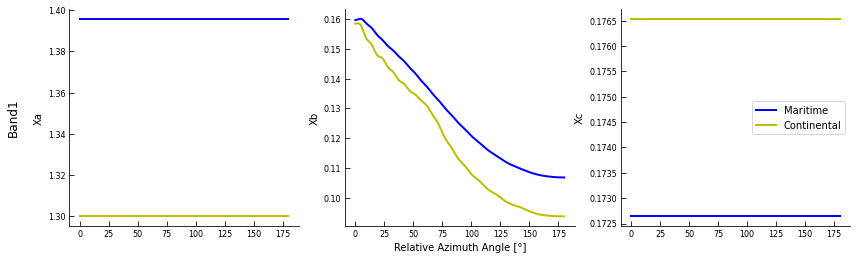

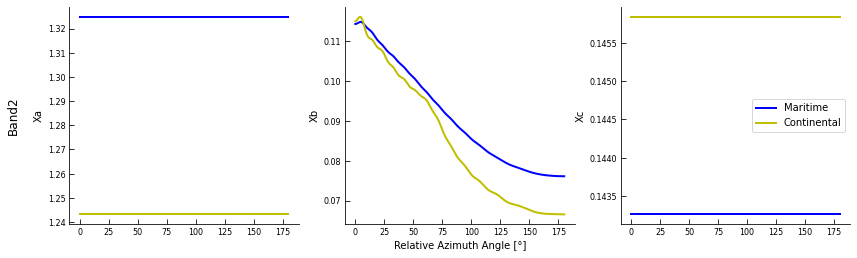

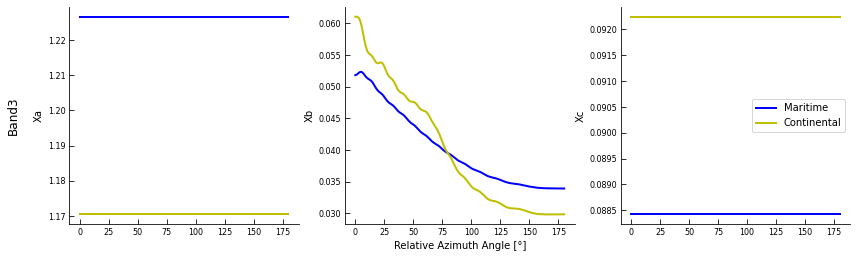

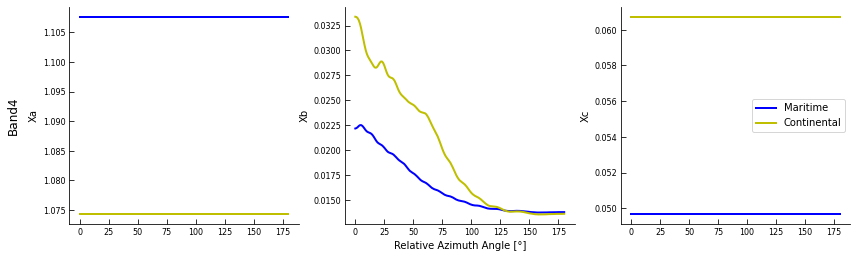

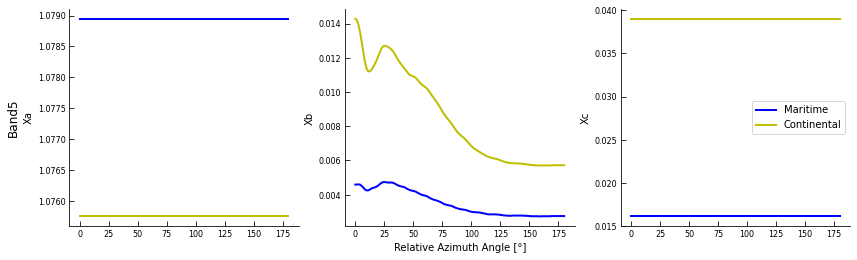

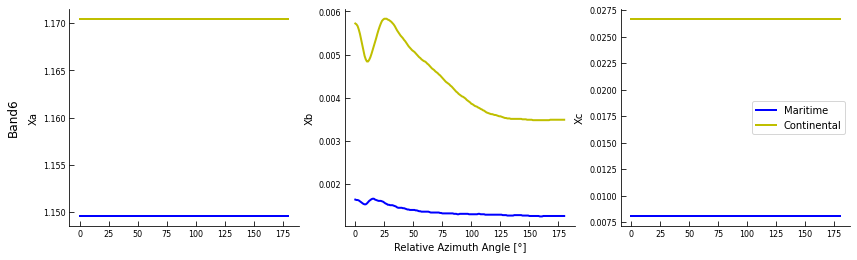

In [161]:
_input = raa
_para = 'Relative Azimuth Angle [°]'
for b in range(1,7):

    wl_band = "/data01/people/liwei/AHI_AC/AHI_SRF/sixs_band{}.csv".format(b)

    band = np.loadtxt(wl_band,delimiter=",")

    X = Parallel(n_jobs=20)(delayed(raa_6s)(i,r) \
                                          for i in range (2)\
                                          for r in range (len(_input)))
    X = np.array(X)
    X1 = X[:,0]
    X2 = X[:,1]
    X3 = X[:,2]
    fig ,axes = plt.subplots(1,3, figsize=(14, 4))

    make_fig(0,_input,X1,_para,'a')
    make_fig(1,_input,X2,_para,'b')
    make_fig(2,_input,X3,_para,'c')
    plt.suptitle('Band{}'.format(b),fontsize=12,y=0.57,x=0.07,rotation=90)
    plt.xlabel("{}".format(_para),fontsize=10,x=-0.7)

    plt.legend(loc=0)
    fig.savefig('{}_RAA.jpg'.format(b),dpi = 1000,bbox_inches = 'tight')
    plt.show()